# Task for today:

- compute the error between Lagrange interpolation for equispaced points (in "approximate Linfty") and a given function when the degree increases
- compute the error between Lagrange interpolation for Chebyshev (in "approximate Linfty") and a given function when the degree increases
- compute the error between Bernstein approximation (in "approximate Linfty") and a given function when the degree increases
- compute the L2 projection and compute the error ("in approximate Linfty") norm and compare with previous results


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import scipy.special

def lagrange(i, q, x):
    return product([(x-qj)/(q[i]-qj) for qj in q if qj != q[i]], axis=0)

def bernstein(i, q, x):
    n = len(q)-1
    return scipy.special.binom(n,i)*(1-x)**(n-i)*x**i

def cheb(n):
    return numpy.polynomial.chebyshev.chebgauss(n)[0]*.5+.5

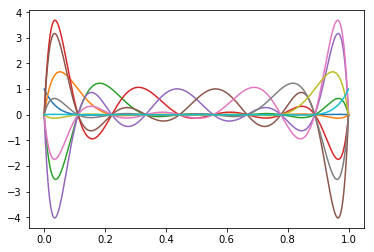

In [5]:
x = linspace(0,1,1025)
q = linspace(0,1,10)
y = array([lagrange(i,q,x) for i in range(len(q))])
_ = plot(x, y.T)

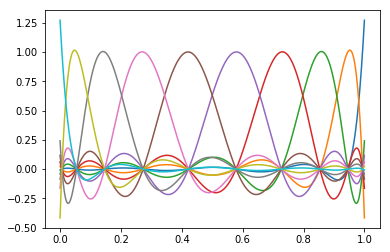

In [6]:
q = cheb(10)
y = array([lagrange(i,q,x) for i in range(len(q))])
_ = plot(x, y.T)

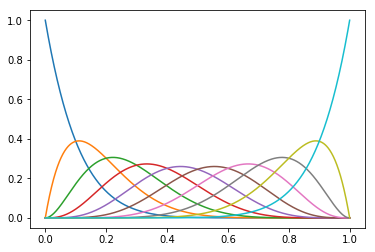

In [7]:
q = linspace(0,1,10)
y = array([bernstein(i,q,x) for i in range(len(q))])
_ = plot(x, y.T)

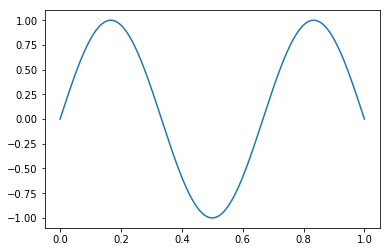

In [8]:
def myfun(x):
    return 1/(1+100*(x-.5)**2)

def myfun(x):
    return sin(3*numpy.pi*x)


plot(x, myfun(x))

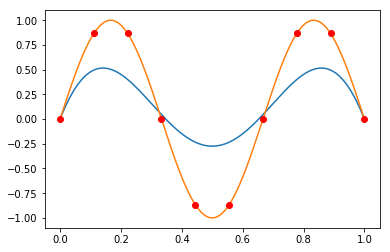

In [9]:
p = y.T.dot(myfun(q))
f = myfun(x)

plot(x,p)
plot(x,f)
plot(q,myfun(q), 'or')

In [10]:
linfty = max(abs(f-p))
linfty

0.72598414958382995

In [11]:
def error(q, myfun, interpolation=lagrange) :    
    y = array([interpolation(i,q,x) for i in range(len(q))])
    p = y.T.dot(myfun(q))
    f = myfun(x)
    return (max(abs(f-p)))

In [12]:
N = range(3, 30)
error_equispaced = []
error_cheb = []
error_bernstein = []
for n in N:
    error_cheb.append(error(cheb(n), myfun))
    error_equispaced.append(error(linspace(0,1,n), myfun))
    error_bernstein.append(error(linspace(0,1,n), myfun, bernstein))


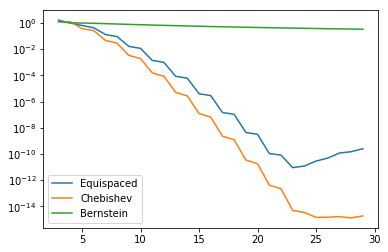

In [13]:
semilogy(N, error_equispaced)
semilogy(N, error_cheb)
semilogy(N, error_bernstein)
_ = legend(['Equispaced','Chebishev','Bernstein'])

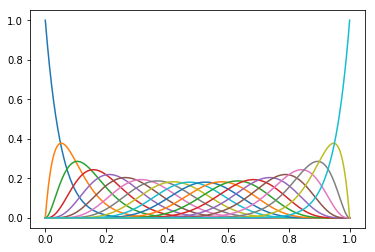

In [14]:
q = linspace(0,1,20)
y = array([bernstein(i,q,x) for i in range(len(q))])
_ = plot(x, y.T)

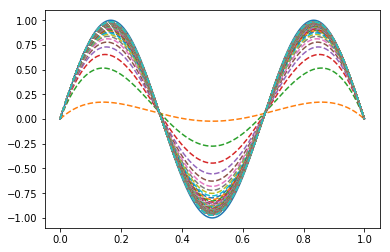

In [15]:
N = range(5,400,5)
plot(x,myfun(x))

for n in N:
    q = linspace(0,1,n)
    y = array([bernstein(i,q,x) for i in range(len(q))])
    p = y.T.dot(myfun(q))
    _ = plot(x, p, '--')


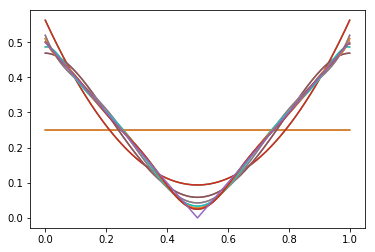

In [17]:
def myfun(x):
    return abs(x-.5)

import scipy
from scipy.integrate import quad as integrate

N = range(1,15)

for n in N:
    M = zeros((n,n))

    for i in range(n):
        for j in range(n):
            M[i,j] = 1.0/(i+j+1)

    F = array([integrate(lambda x: myfun(x)*x**i, 0,1)[0] for i in range(n)])
    pi = linalg.solve(M, F)
    p = sum([x**i*pi[i] for i in range(n)], axis=0)
    plot(x,p)
plot(x,myfun(x))

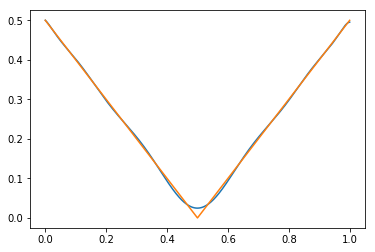

In [18]:
plot(x,p)
plot(x,myfun(x))

In [19]:
max(abs(p-myfun(x)))

0.024752530313868037

Why do we get these errors in the L2 projection? The matrix M is not well conditioned...

In [23]:
linalg.cond(M)

2.5514988483782115e+17

Let's turn to numerical quadrature, and Legendre polynomials (for which M is the identity by construction...)

In [24]:
from numpy.polynomial.legendre import leggauss 
from numpy.polynomial.legendre import legval #
from numpy.polynomial.legendre import Legendre 

In [28]:
n = 10 #polynomial projections of order 10: our algorithm is exact up to 2N+1:30
N = n+5 #15 points


q,w = leggauss(N) #(quadrature points, quadrature weights)=legendregauss
w *= .5  #leggauss uses [-1,1]. This is to get to [0,1]
q +=1
q /=2

#def bernstein(i, q, x):
#    n = len(q)-1
#    return scipy.special.binom(n,i)*(1-x)**(n-i)*x**i


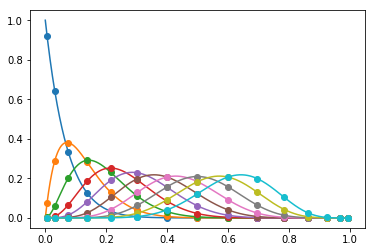

In [78]:
#Lagrange basis
#v = array([Legendre.basis(i, domain=[0,1])(x) for i in range(n)]) #evaluated in x (1000)
#vq = array([Legendre.basis(i, domain=[0,1])(q) for i in range(n)])#evaluated in q (N)


_ = plot(x,v.T)
_ = plot(q, vq.T, 'o')

Check that we get a diagonal matrix as M:

In [67]:
v.shape,vq.shape #(number of basys, v:number of elements of x or vq:quadrature points)
#vq[i,m]= v_i[q_m]
#M[i,j]=.dot(vi,vj)=\int v_i(t) v_j(t) dt= \sum_{m=0 upto n_q-1} v_i(q_m) v_j(q_m) w_m      (*)

((10, 1025), (10, 15))

In [68]:
M = einsum('im, jm, m->ij', vq, vq, w)
linalg.cond(M) #M it's orthogonal, not orthonormal:that's why M!=identity
1+1e-16

1.0

In [71]:
M2=M*(abs(M)>1e-14) #makes 0 (False) everything which is <e-14
#u expect to see a diagonal matrix looking at cancellation errors. I have n_q entries and I have eps=e-16
#so I expect the final error to be e-15*n_q. Here n_q=15, so fine. Thatìs because I have 3 elements in the
#product (*) and they're all <1, so the product smooth eps, while the sum cumulates it
print(M2)
diag = array([M[i,i] for i in range(n)])

[[  3.44827586e-02   1.72413793e-02   8.30140485e-03   3.83141762e-03
    1.68582375e-03   7.02426564e-04   2.74862569e-04   9.99500250e-05
    3.33166750e-05   9.99500250e-06]
 [  1.72413793e-02   1.78799489e-02   1.34099617e-02   8.58237548e-03
    4.91698595e-03   2.56538397e-03   1.22438781e-03   5.33066800e-04
    2.09895052e-04   7.36473868e-05]
 [  8.30140485e-03   1.34099617e-02   1.39463602e-02   1.16219668e-02
    8.33749792e-03   5.30568049e-03   3.03181742e-03   1.55922039e-03
    7.18062022e-04   2.92543787e-04]
 [  3.83141762e-03   8.58237548e-03   1.16219668e-02   1.21272697e-02
    1.06113610e-02   8.08484647e-03   5.45727136e-03   3.28256924e-03
    1.75526272e-03   8.26005986e-04]
 [  1.68582375e-03   4.91698595e-03   8.33749792e-03   1.06113610e-02
    1.11166639e-02   1.00049975e-02   7.89868224e-03   5.51653998e-03
    3.40727469e-03   1.84560712e-03]
 [  7.02426564e-04   2.56538397e-03   5.30568049e-03   8.08484647e-03
    1.00049975e-02   1.05315763e-02   9.65394

In [72]:
diag

array([ 0.03448276,  0.01787995,  0.01394636,  0.01212727,  0.01111666,
        0.01053158,  0.01022182,  0.01012447,  0.01022182,  0.01053158])

Now perform the integral

In [73]:
pi = sum(vq*myfun(q)*w, axis=1)

And plot the function, and its interpolation

In [74]:
p = (pi/diag).dot(v) #/diag because they're not orthonormal

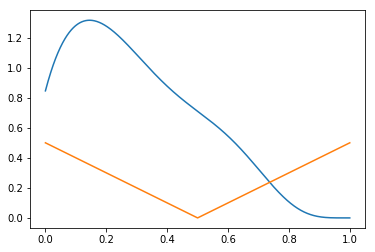

In [75]:
plot(x, p)
_ = plot(x, myfun(x))

In [63]:
#bernstein polynomial as basis evaluated at quadrature points. The result should be identical because the best
#L2 projection is unique and does not depend on which basis u express it

In [107]:
basis_1=lambda i,q: Legendre.basis(i,domain=[0,1])(q)
basis_2=lambda i,x: bernstein(i,linspace(0,1,n),x)

def l2_projection(n,myfun,basis):
    N = n+5 #15 points

    q,w = leggauss(N) #(quadrature points, quadrature weights)=legendregauss
    w *= .5  #leggauss uses [-1,1]. This is to get to [0,1]
    q +=1
    q /=2
    vq = array([basis(i,q) for i in range(n)])#evaluated in q (N)
    M = einsum('im, jm, m->ij', vq, vq, w)
    F =sum(vq*myfun(q)*w,axis=1)
    p=linalg.solve(M,F)
    return p
    

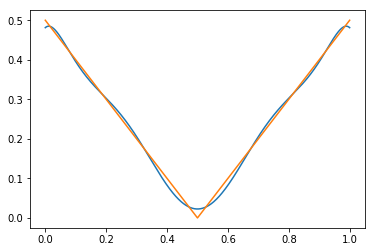

In [111]:
n=10
v1=array([basis_2(i,x) for i in range(n)])
p1=l2_projection(n,myfun,basis_2)

p=p1.dot(v1)
plot(x,p)
_=plot(x,myfun(x))

#bernstein conditin number grows very slower than lagrange one when n increases